# Feature Importance

- With the best performing model and a SMOTE() balanced dataset I identify the most important genes responsible for classifying each cell
- Features/genes for each cell are first obtained by filtering for the top 10 most positive and top 10 most negative Logistic Regression coefficients
- Then, these genes are compared to the largest SHAPLY value genes, which is a model agnostic approach. 

In [31]:
#load libraries
import sklearn
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import mygene
import shap

#custom display options
warnings.filterwarnings('ignore')
mpl.rcParams['figure.dpi'] = 150
pd.set_option('display.max_rows', 50)

### Load training data acquired from the "1_Class_Imbalance.ipynb" notebook. 

In [2]:
X_train = pd.read_csv("~/scRNA_seq_project/X_train.csv",sep=",", header=0, index_col=0)
Y_train = pd.read_csv("~/scRNA_seq_project/Y_train.csv",sep=",", header=0, index_col=0).cls_id
X_train.columns

Index(['ENSG00000163736', 'ENSG00000254709', 'ENSG00000163737',
       'ENSG00000127920', 'ENSG00000120885', 'ENSG00000168497',
       'ENSG00000143546', 'ENSG00000163220', 'ENSG00000115523',
       'ENSG00000132465',
       ...
       'ENSG00000128274', 'ENSG00000130429', 'ENSG00000133401',
       'ENSG00000124302', 'ENSG00000167522', 'ENSG00000148834',
       'ENSG00000246379', 'ENSG00000148655', 'ENSG00000166707',
       'ENSG00000142937'],
      dtype='object', length=1000)

### Convert the Ensembl ID to their gene name

In [3]:
mg = mygene.MyGeneInfo()
gene_symbols = mg.querymany(X_train.columns, scopes = 'ensembl.gene',fields = 'symbol',species = 'human')
df_gene_symbols = pd.DataFrame(gene_symbols)
df_gene_symbols['symbol'] = df_gene_symbols['symbol'].fillna(df_gene_symbols['query'])
X_train.columns = df_gene_symbols['symbol']
X_train.columns

Index(['PPBP', 'IGLL5', 'PF4', 'GNG11', 'CLU', 'CAVIN2', 'S100A8', 'S100A9',
       'GNLY', 'JCHAIN',
       ...
       'A4GALT', 'ARPC1B', 'PDZD2', 'CHST8', 'ANKRD11', 'GSTO1', 'GNAO1-DT',
       'LRMDA', 'ZCCHC18', 'RPS8'],
      dtype='object', name='symbol', length=1000)

### Use the SMOTE() balanced dataset to fit an optimized Logistic Regression model. 

In [4]:
lr_steps = [('over', SMOTE()), ('model', LogisticRegression(**{'solver': 'sag', 'penalty': 'none', 'max_iter': 500, 'fit_intercept': True, 'dual': False, 'C': 0.5}))]
lr_pipeline = Pipeline(steps=lr_steps)
lr_pipeline.fit(X_train,Y_train)

### Find the top 10 most positive and top 10 most negative Logistic Regression coefficients for each cell type

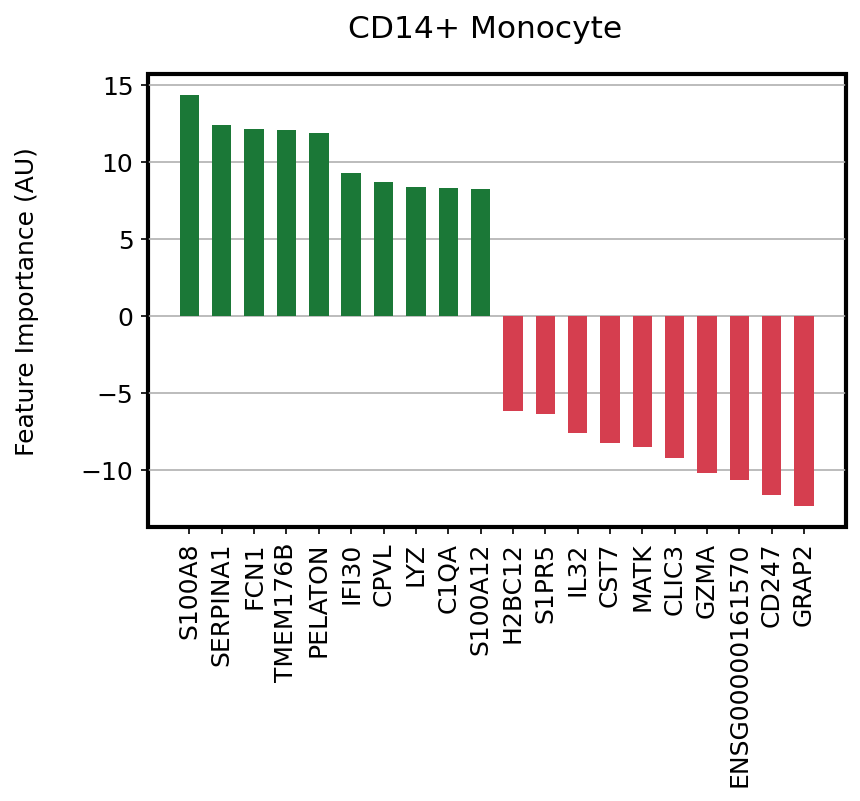

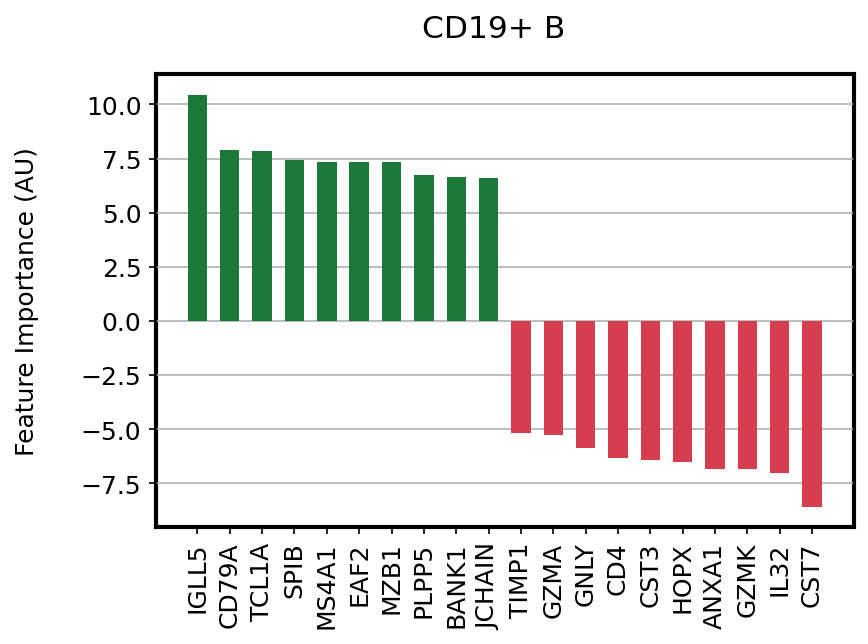

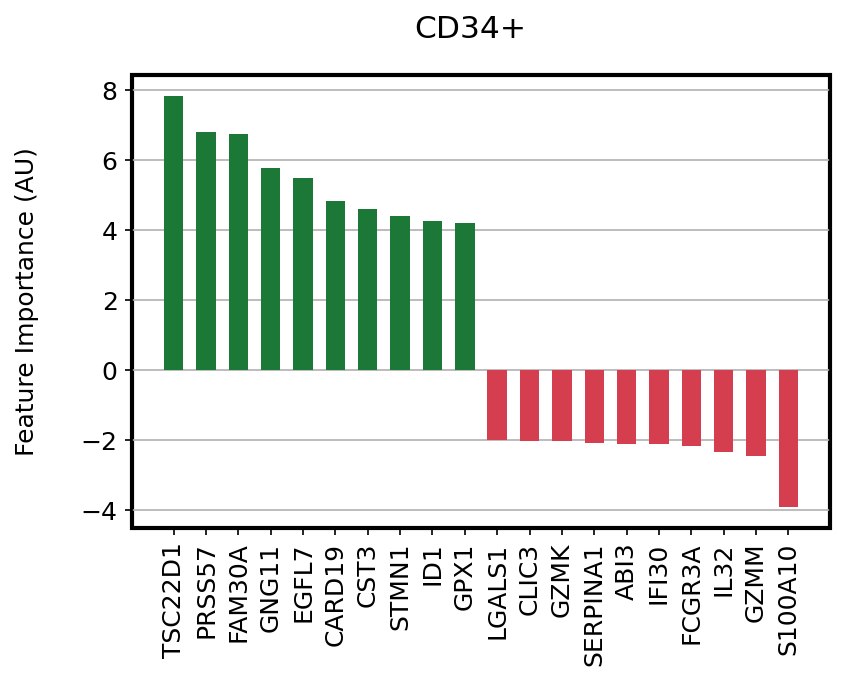

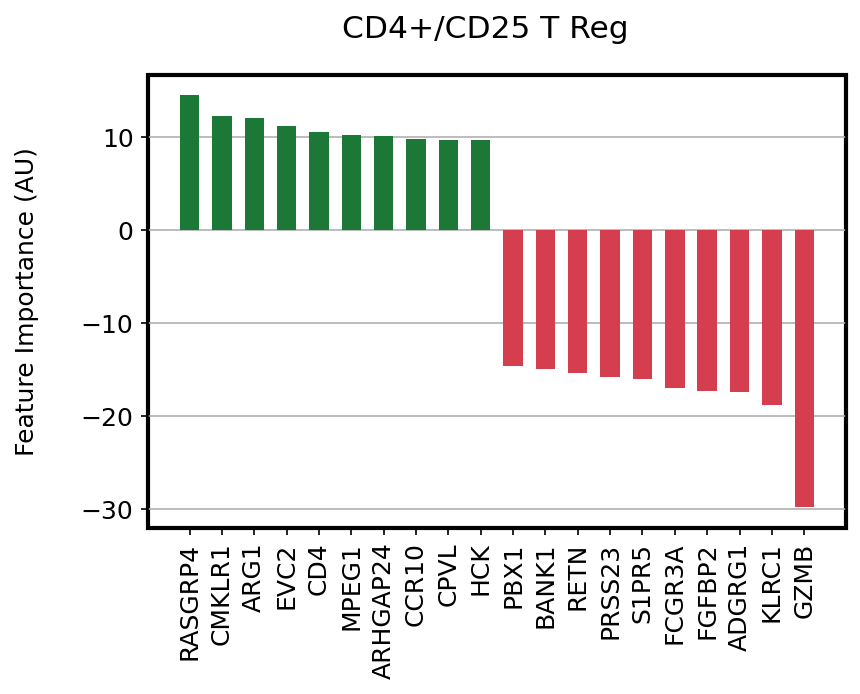

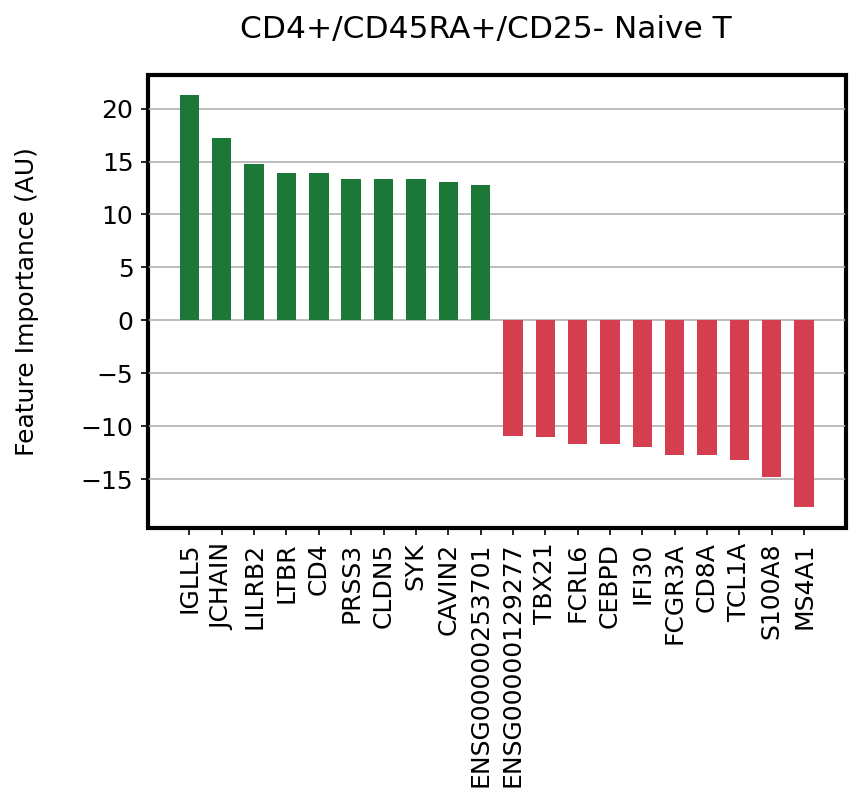

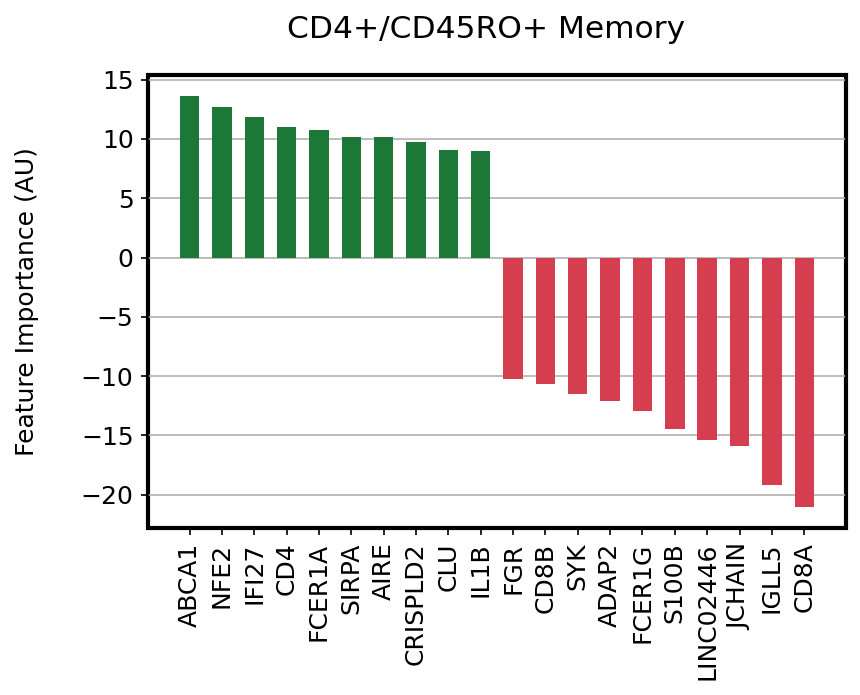

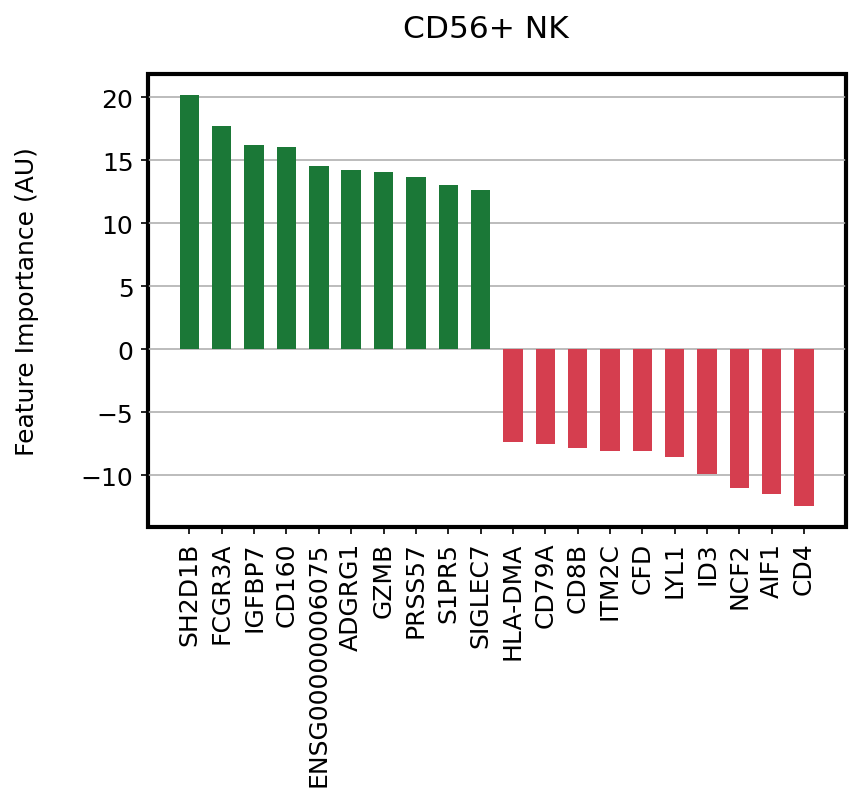

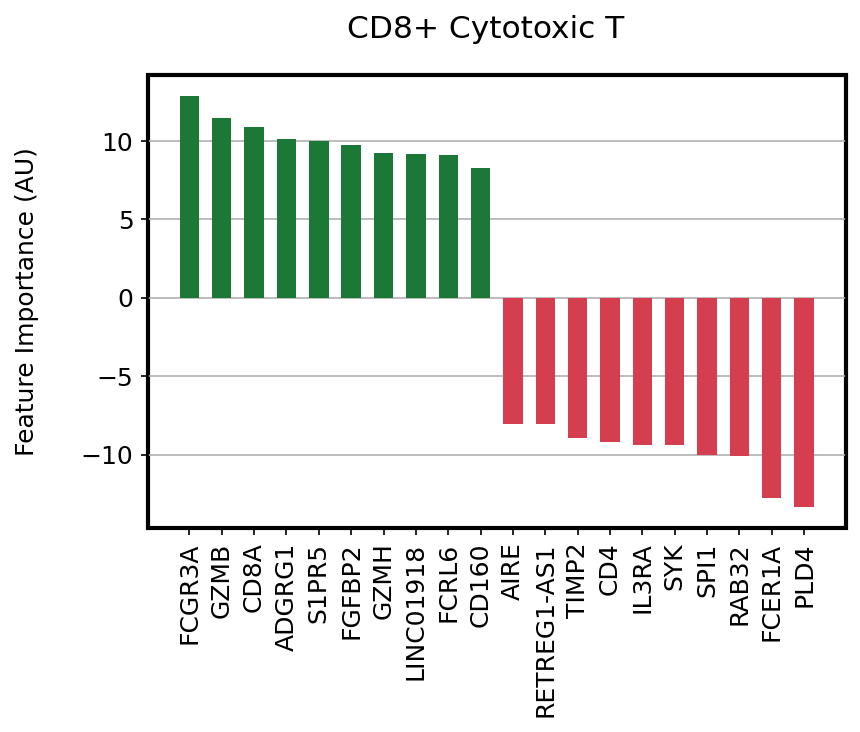

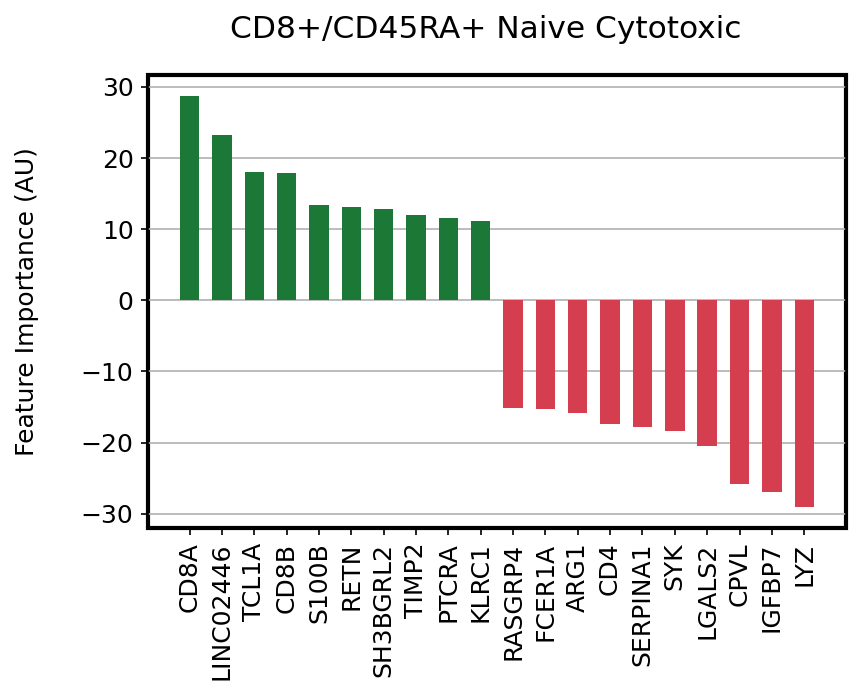

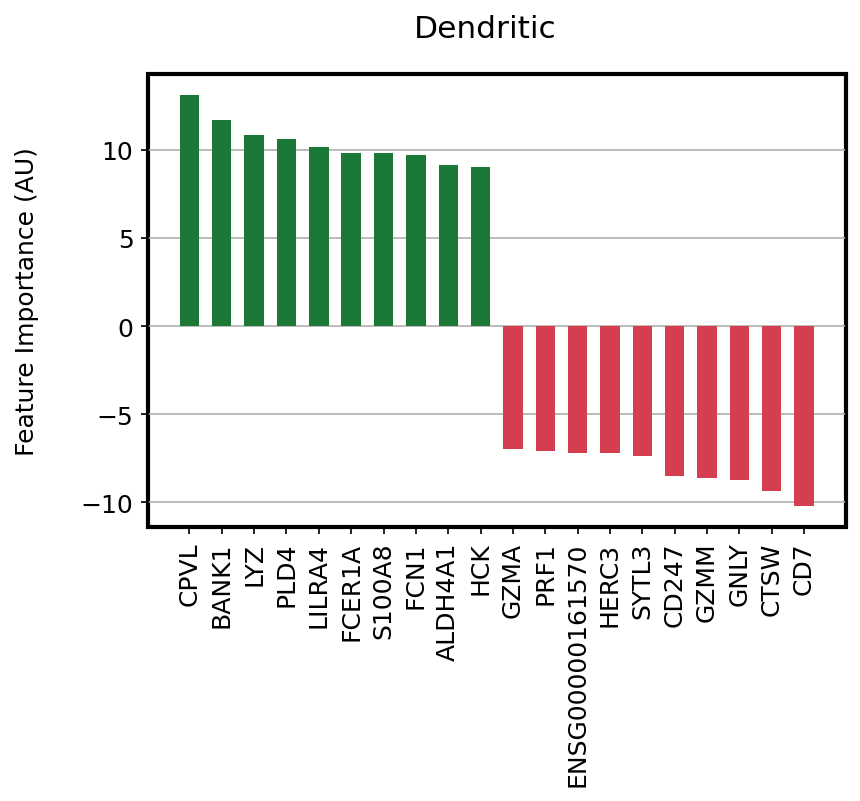

In [37]:
for i in range(10):
    df_allfeatures = pd.DataFrame({"genes":X_train.columns, "coefficient" : lr_pipeline['model'].coef_[i]})
    df_allfeatures = df_allfeatures.sort_values('coefficient',ascending = False)
    df_features = pd.concat([df_allfeatures.head(10),df_allfeatures.tail(10)])
    
    ind = np.arange(20)
    fig, ax = plt.subplots(figsize = (6, 4))
    colours = ['#d53e4f' if (x < 0) else '#1b7837' for x in df_features.coefficient]
    logistic_bar = ax.bar(ind, df_features.coefficient,alpha=1.0,width = 0.6,capsize = 10, color = colours,zorder = 3)
    ax.set_ylabel("Feature Importance (AU)", size = 12)
    ax.set_xlabel("", size = 12)
    ax.set_xticks(ind,labels = df_features.genes)
    ax.set_xticklabels(df_features.genes,rotation = 90)
    ax.tick_params(axis='both', labelsize=12)
    ax.yaxis.grid(True,zorder = 0)
    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 20

    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth('2') 
    fig.suptitle(np.unique(Y_train)[i], fontsize=15)
    
    cell_type = np.unique(Y_train)[i]
    cell_type = cell_type.replace("/","_")
    plt.savefig(cell_type + '_Features.png',dpi = 600,bbox_inches='tight')

### An alternative way to acquire the most important features for classifying each cell is to use SHAPLY values.

In [5]:
masker = shap.maskers.Independent(data=X_train)
explainer = shap.LinearExplainer(lr_pipeline.named_steps["model"], masker=masker, feature_names=X_train.columns, algorithm="linear")
shap_values = explainer.shap_values(X_train)

print(len(shap_values))
print(shap_values[0].shape)

10
(54848, 1000)


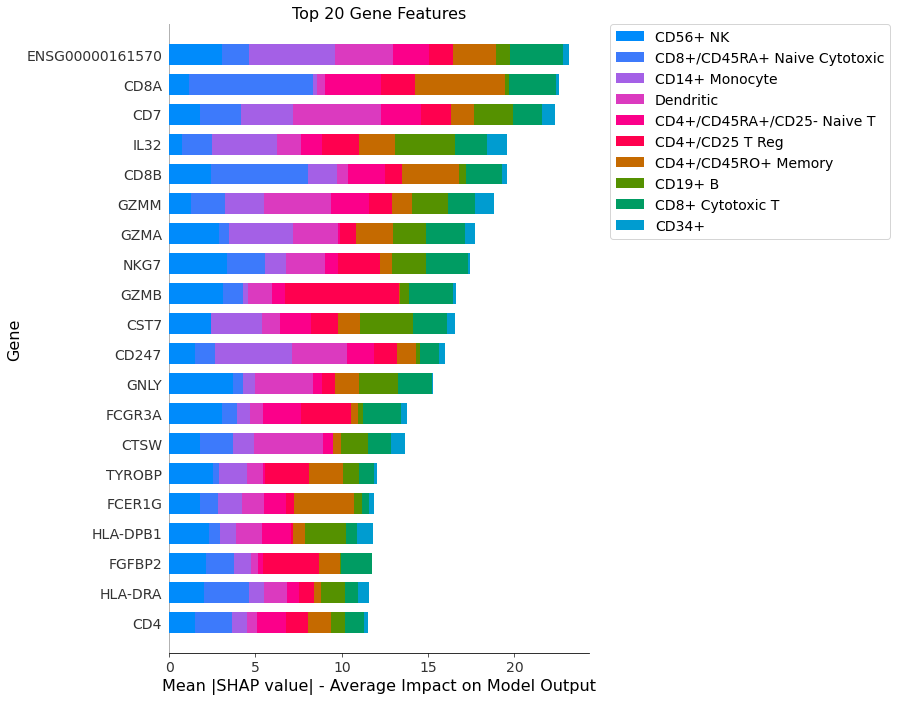

In [27]:
shap.summary_plot(shap_values,X_train,class_names = lr_pipeline['model'].classes_,max_display = 20, show = False)
fig, ax = plt.gcf(), plt.gca()

# Modifying main plot parameters
ax.tick_params(labelsize=14)
ax.set_xlabel("Mean |SHAP value| - Average Impact on Model Output", fontsize=16)
ax.set_ylabel("Gene", fontsize = 16)
ax.set_title('Top 20 Gene Features', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0,fontsize = 14)
vis = ax.get_figure()
vis.savefig('overall_SHAPLY_Features.pdf', bbox_inches='tight')

plt.show()

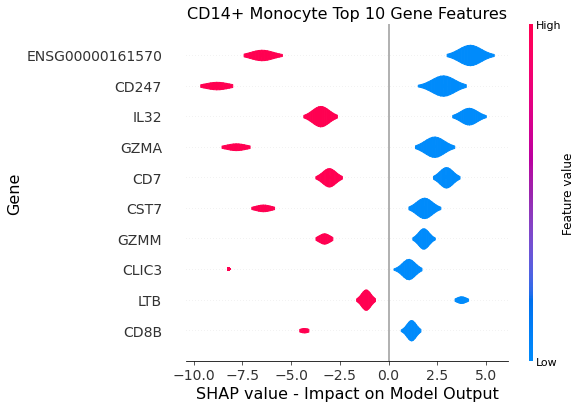

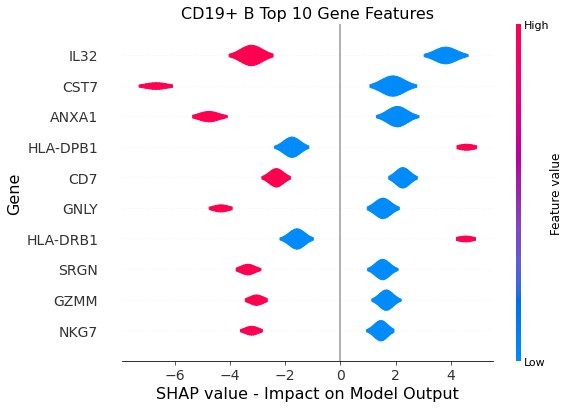

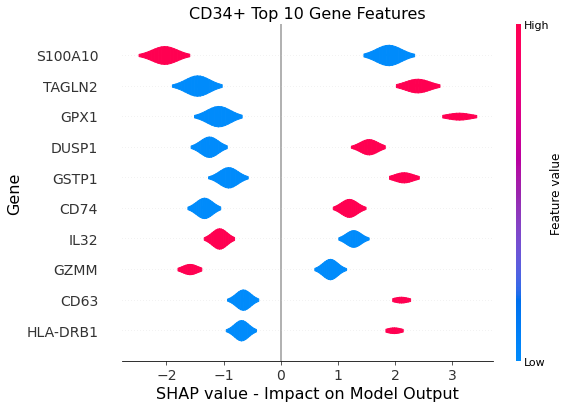

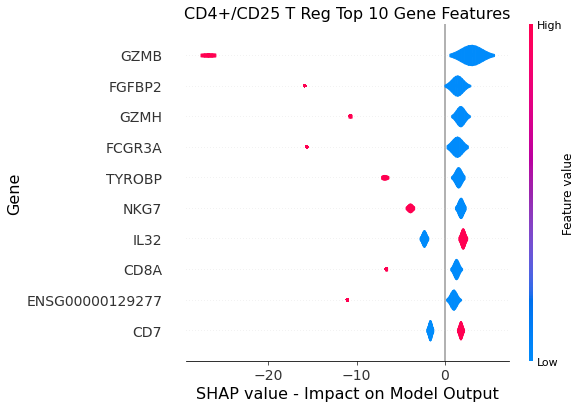

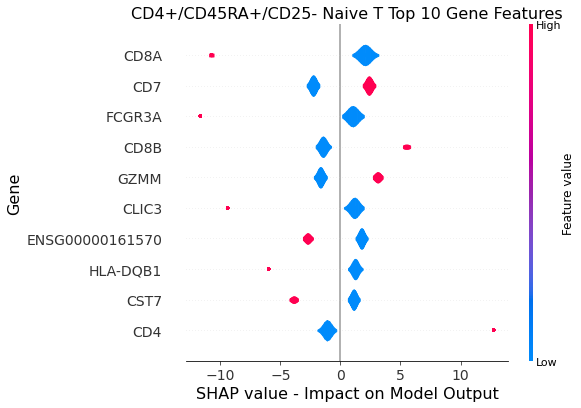

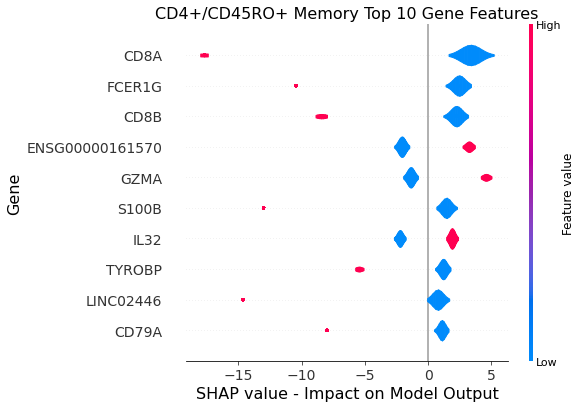

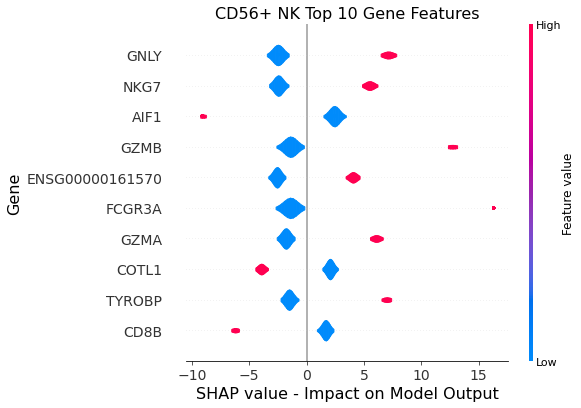

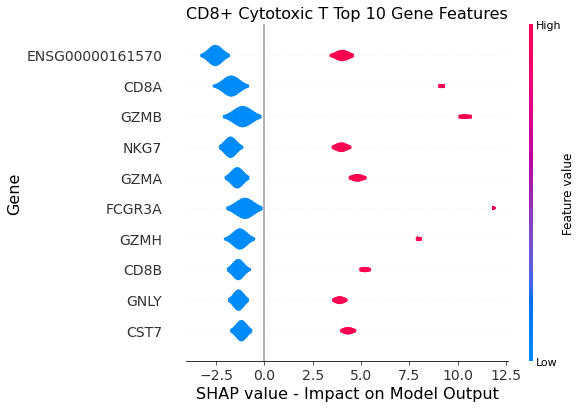

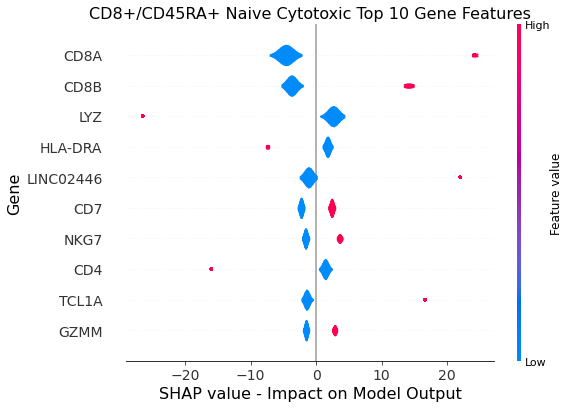

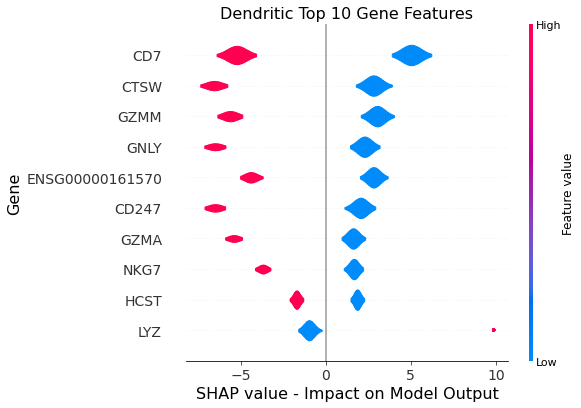

In [28]:
for i in range(10):
    shap.summary_plot(shap_values[i],X_train,max_display = 10, plot_type = "violin",show = False)
    
    fig, ax = plt.gcf(), plt.gca()
    cell_type = np.unique(Y_train)[i]
    
    # Modifying main plot parameters
    ax.tick_params(labelsize=14)
    ax.set_xlabel("SHAP value - Impact on Model Output", fontsize=16)
    ax.set_ylabel("Gene", fontsize = 16)
    ax.set_title(cell_type + ' Top 10 Gene Features', fontsize=16)
    
    cell_type = cell_type.replace("/","_")
    vis = ax.get_figure()
    vis.savefig(cell_type + '_SHAP_Features.pdf', bbox_inches='tight')
    
    plt.show()